# Part 1: Data Engineering

This notebook showcases how to train a ranking model that re-ranks results returned by Azure Cognitive Search.

Through this experiment, we are going to:
1. Use Azure Cognitive Search's new capability to extract text-based similarity features that describe query-to-document relationships.
2. Do additional feature engineering to enhance our dataset further.
3. Train a model using [XGBOOST](https://xgboost.readthedocs.io/en/latest/)
4. Evaluate the ranking produced by the trained model against the base Azure Cognitive Search ranking using the [NDCG metric](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG).

The following diagram shows what training and using a Learn To Rank approach to re-rank results could look like in Azure Cognitive Search. This experiment focuses on the top diagram labeled "L2 Ranker Training"

![l2r_diagram](l2r_diagram.png)

### Experiment setup

This experiment uses a dataset containing **7102 articles** from the **docs.microsoft.com** website. Each article contains a title, body, description, list of api names and a url path. Articles were augmented using the [key phrase extraction cognitive skill](https://docs.microsoft.com/azure/search/cognitive-search-skill-keyphrases) as well as with popular search terms that led to those articles. Additionally, we augmented the articles with easy to compute metadata that will be leveraged when training, such as the number of sections and tables in each article, as well as the normalized page views count.

You can find the full index definition at `azs_helpers/index_schema/docs-multilingual-20200217.json`

```json
{
  "name": "docs-multilingual-20200217",
  "fields": [
    {
      "name": "id",
      "type": "Edm.String",
      "facetable": true,
        ...
    },
    ...
  ]
}
```

The experiment also relies on a labeled training set containing over 900 unique queries evaluated against various articles. We refer to this data as the "judgment" list, which will be used as the ground truth when evaluating ranking. Each query is evaluated against 1 to 10 different documents, and for each, provides a "grade" representing how relevant that specific document is to that query. A value of 10 indicates high relevance, while a value of 1 indicates lower relevance.

The judgment list can be found at `data/raw/msft_docs_labels.csv`. Here's an excerpt from the judgment list:

| query | url | grade |
| --- | --- | --- |
| powershell | https://docs.microsoft.com/en-us/powershell/scripting/overview | 10 |
| powershell | https://docs.microsoft.com/en-us/powershell/ | 9 |
| powershell | https://docs.microsoft.com/en-us/windows-server/administration/windows-commands/powershell | 8 |
| powershell | https://docs.microsoft.com/en-us/powershell/scripting/install/installing-powershell | 7 |

Where "powershell" is an example term that can be queried, the urls represent identifier to documents in the index, and the numbers are their relevance "grade".

#### Configuration
To run this experiment, you need to ingest the dataset into a search index. The dataset includes 7102 documents and will require about 250mb of storage available in your service. 

This experiment will automatically:

1. Create an [index](https://docs.microsoft.com/azure/search/search-what-is-an-index) with the expected definition
2. Create a [datasource](https://docs.microsoft.com/azure/search/search-indexer-overview#supported-data-sources) to connect to a public Azure Blob storage container we prepared containing the dataset
3. Create an [indexer](https://docs.microsoft.com/azure/search/search-indexer-overview) that will start ingesting the documents into your newly created index  


Details and secrets about your search service should be added to a `config.json` file of this format:

```json
{
   "service_name": "YOUR_SERVICE_NAME",
   "endpoint": "https://YOUR_SERVICE_NAME.search.windows.net",
   "api_version": "2019-05-06-Preview",
   "api_key": "YOUR_API_KEY",
   "index_name": "msft-docs"
}
```   
Be sure to use an API key with admin access 

The config is located at `config/config.json`. Please fill it out with your service endpoint and secrets.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings(action='once')

from pathlib import Path
import pandas as pd
import azs_helpers.l2r_helper as azs
from azs_helpers.azure_search_client import azure_search_client as azs_client 

service_metadata_config_path = Path.cwd() / 'config' / 'config.json'
azs_service = azs_client.from_json(service_metadata_config_path)

judgment_file_path = Path.cwd() / 'data' / 'raw' / 'msft_docs_labels.csv'
judgments = pd.read_csv(judgment_file_path)

# index creations and ingestion
azs_service.create_index()
azs_service.ingest_documents_from_blob_storage(expected_document_count=7102)

/home/homeuser/anaconda3/envs/azs-l2r/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'azszorl.eastus.cloudapp.azure.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Index docs-multilingual-20200217 already exists. Skipping creation.
Index docs-multilingual-20200217 contains all 7102 documents. Skipping ingesting documents.


### Extracting features from search service

The following functions are designed to efficiently use the search service to extract document-query features.

1. We **"filter"** each query to only consider the documents we want to judge. This is achieved by adding a **"[filter](https://docs.microsoft.com/azure/search/search-filters)"** clause to our search query which will restrict the results to the group of documents contained in the group of documents we have judgment values for.
2. We set **"featuresMode"** to "enabled". This will tell the search service to return additional features with the results, including per-field similarity scores.
3. We use the **"[select](https://docs.microsoft.com/azure/search/search-query-odata-select)"** clause to only return the url of each documents, as well as a few non-text based fields that could potentially be used as features. This will greatly reduce the amount of data that needs to be transfered between the server and the client.
4. We use the **"[searchFields](https://docs.microsoft.com/rest/api/searchservice/search-documents#searchfieldsstring-optional)"** parameter to select which text-based fields we want to include in the search process. Those fields will be the only ones for which the service will extract text-based features from (such as per-field similarity).
5. We set the **"[scoringStatistics](https://docs.microsoft.com/azure/search/index-similarity-and-scoring#scoring-statistics)"** parameter to global, which will give us more consistent and predictable scoring by calculating index statistics at the index level, rather than at the shard level.

An example JSON payload of a [search request](https://docs.microsoft.com/rest/api/searchservice/search-documents) to efficiently extract features for the search query ".net core" against a specific subset of documents would look like this:

```json
{
    "search": ".net core",
    "featuresMode": "enabled",
    "select": "title_en_us, url_en_us, sectionCount, tableCount, normalized_pageview",
    "searchFields": "body_en_us,description_en_us,title_en_us,apiNames,urlPath,searchTerms, keyPhrases_en_us",
    "scoringStatistics": "global",
    "filter": "search.in(url_en_us, 'https://docs.microsoft.com/en-us/dotnet/core/, https://docs.microsoft.com/en-us/dotnet/core/about, https://docs.microsoft.com/en-us/dotnet/, https://docs.microsoft.com/en-us/aspnet/core/, https://docs.microsoft.com/en-us/dotnet/core/whats-new/dotnet-core-3-1, https://docs.microsoft.com/en-us/dotnet/core/install/sdk, https://docs.microsoft.com/en-us/dotnet/core/get-started, https://docs.microsoft.com/en-us/dotnet/core/install/linux-package-manager-ubuntu-1904, https://docs.microsoft.com/en-us/dotnet/core/tools/global-tools, https://docs.microsoft.com/en-us/dotnet/core/tutorials/')"
}
```

And the expect response to such a query would have the following format:

```json
"value": [
 {
    "@search.score": 5.1958685,
    "@search.features": {
        "description_en_us": {
            "uniqueTokenMatches": 1.0,
            "similarityScore": 0.29541412,
            "termFrequency" : 2
        },
        "body_en_us": {
            "uniqueTokenMatches": 3.0,
            "similarityScore": 0.36644348400000004,
            "termFrequency" : 4
        },
        "keyPhrases_en_us": {
            "uniqueTokenMatches": 3.0,
            "similarityScore": 0.35014877,
            "termFrequency" : 3
        },
        "title_en_us": {
            "uniqueTokenMatches": 3.0,
            "similarityScore": 1.75451557,
            "termFrequency" : 6
        },
        "urlPath": {
            "uniqueTokenMatches": 2.0,
            "similarityScore": 1.07175103,
            "termFrequency" : 2
        },
        "searchTerms": {
            "uniqueTokenMatches": 3.0,
            "similarityScore": 1.3575956200000001,
            "termFrequency" : 3
        }
    },
    "normalized_pageview": 125,
    "tableCount": 2,
    "sectionCount": 7,
    "url_en_us": "https://docs.microsoft.com/en-us/dotnet/core/"
}]
```

In [2]:
def get_search_results(service, query, urls_filter):
    search_request_body = {
        "search": azs.escape_query(query),
        "featuresMode": "enabled",
        "select": "title_en_us, url_en_us, sectionCount, tableCount, normalized_pageview", 
        "searchFields": "body_en_us, description_en_us, title_en_us, apiNames, urlPath, searchTerms, keyPhrases_en_us",
        "scoringStatistics": "global",
        "count": "true"
    }
    if len(urls_filter) > 0:
        search_request_body["filter"] = "search.in(url_en_us, '{0}')".format(", ".join(url for url in urls_filter))
    
    return service.search(search_request_body)

def get_features(service, query, group):
    urls = group['url'].values.tolist()
    
    search_results = get_search_results(service, query, urls)

    # this will flatten the search json response into a panda dataframe
    azs_features = pd.json_normalize(search_results)
    
    # we add the data extracted from Azure Cognitive Search to our labeled data by merging them on the "url" field
    merged_results = group.join(azs_features.set_index('url_en_us'), on='url')

    return merged_results

### Make parallel calls to the search service to extract features

To extract all the features from our dataset we start by grouping the judgment list by query. This will provide us with a list of judged documents for each query. Each call to the search service will use the query from the group with filters to make sure we only return the documents from the group. In this dataset, we can expect aproximately 900 queries.

To quickly execute those queries, we setup a thread pool executor which will run the queries in parallel. The level of parallelism can be changed to accomodate different search service capacity - use 15 for Basic, 30 for Standard and higher SKUs.

Note: In the cell output, "Wall time" denotes the total real-world time it took to run this cell.

In [3]:
%%time

import concurrent
import datetime
from itertools import chain

# filter out queries with only one document. These are trivial and useless.
query_groups = judgments.groupby('query').filter(lambda x: len(x) > 1).groupby('query')

executor = concurrent.futures.ThreadPoolExecutor(15)
futures = [executor.submit(get_features, azs_service, query, group) for (query, group) in query_groups]
concurrent.futures.wait(futures)

all_features = pd.concat([future.result() for future in futures if future], sort=False).fillna(0)

CPU times: user 10.5 s, sys: 399 ms, total: 10.9 s
Wall time: 30 s


## Visualize our Dataset

Now that the data has finished downloading, let's load our data. Pay attention to a few things in particular:

- **grade** is the ground truth relevance score for this document, where a grade of '10' is most relevant, while a grade of '1' is least relevant. It is an [ordinal variable](https://en.wikipedia.org/wiki/Ordinal_data) ranging from **1 ~ 10**, from least relevant to most relevant.
- **title_en_us** is the English-language title of an article on Microsoft Docs.
- **query** is the search query that led to this document
- All features that begin with an "@" character are computed by the Features API and will be used extensively by the trained model. Other features including properties stored in documents including normalized_pageview, tableCount, and sectionCount.
- Some queries have less than 10 documents. We'll have to keep this fact in mind when preparing our data.

In [4]:
query_groups = all_features.groupby('query')
docs_per_query = query_groups.size()
print(f"Number of unique queries: {len(all_features.groupby('query'))}")
print(f"Number of documents: {len(all_features)}")
print(f"Number of features: {len(all_features.columns)}")
print(f"Fewest docs in a single query: {docs_per_query.min()}")
print(f"Most docs in a single query: {docs_per_query.max()}")

all_features

Number of unique queries: 972
Number of documents: 8679
Number of features: 26
Fewest docs in a single query: 2
Most docs in a single query: 10


,query,url,grade,@search.score,normalized_pageview,tableCount,sectionCount,title_en_us,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,...,@search.features.keyPhrases_en_us.termFrequency,@search.features.title_en_us.uniqueTokenMatches,@search.features.title_en_us.similarityScore,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency
3734,$,https://docs.microsoft.com/en-us/powershell/mo...,10,0.101192,222.160000,1.0,13.0,about_Variables - PowerShell,1.0,0.101192,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3735,$,https://docs.microsoft.com/en-us/windows/win32...,8,0.155940,1.440000,0.0,0.0,Creating a New Computer Account - Win32 apps,1.0,0.155940,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3736,$,https://docs.microsoft.com/en-us/windows-hardw...,6,0.043148,3.600000,1.0,2.0,Pseudo-Register Syntax - Windows drivers,1.0,0.043148,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3737,$,https://docs.microsoft.com/en-us/cpp/build/ref...,4,0.233910,2.680000,0.0,2.0,Special Characters in a Makefile,1.0,0.233910,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3738,$,https://docs.microsoft.com/en-us/windows-hardw...,3,0.090593,2.460000,0.0,2.0,Symbol Syntax and Symbol Matching - Windows dr...,1.0,0.090593,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,zoom,https://docs.microsoft.com/en-us/office/vba/ap...,5,3.183052,0.276596,0.0,3.0,Window.Zoom property (Visio),1.0,0.339155,...,2.0,1.0,1.376789,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0
1779,zoom,https://docs.microsoft.com/en-us/azure/active-...,4,5.304070,14.320000,0.0,9.0,Tutorial: Azure Active Directory single sign-o...,1.0,0.306429,...,11.0,1.0,0.860493,1.0,1.0,1.742096,3.0,1.0,1.032592,1.0
1780,zoom,https://docs.microsoft.com/en-us/dotnet/api/sy...,3,4.034551,0.460000,1.0,5.0,FlowDocumentReader.Zoom Property (System.Windo...,1.0,0.482078,...,4.0,1.0,1.032592,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0
1781,zoom,https://docs.microsoft.com/en-us/office/vba/ap...,2,2.886207,8.640000,0.0,3.0,PageSetup.Zoom property (Excel),1.0,0.169577,...,1.0,1.0,1.376789,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0


### Feature engineering

In this section, we will enrich our model with additional features. As a simple example, we are going to add the title length, in words and in characters.
- You can also add domain-specfic features when you have domain knowledge. In our dataset, we obtained `tableCount` and `sectionCount` with knowledge of each article's structure.  
- In a production setting, you can precompute features and index them ahead of time. This way, they don't need to be re-processed for each query.

We are also going to drop columns of our dataset that we won't be using for the training process, such as raw url, title and query text. 

In [5]:
from pprint import pprint

def customize_features(features):
    # adding a query_id column will help us group the data per query later in training
    if 'query_id' not in features:
        features['query_id'] = features.groupby('query').ngroup()
    
    if ('title_en_us' in features):
        features['title_en_us'] = features['title_en_us'].map(lambda title: str(title))
        features['title_length_in_words'] = features['title_en_us'].map(lambda title: float(len(title.split())))
        features['title_length_in_chars'] = features['title_en_us'].map(lambda title: float(len(title)))

    # Discard the columns that we no longer need
    features = features.drop(['query', 'url', 'title_en_us'], axis=1, errors='ignore')
    return features

all_features = customize_features(all_features)
print("All features collected:")
pprint(all_features.columns.values)

all_features.head(5)

All features collected:
array(['grade', '@search.score', 'normalized_pageview', 'tableCount',
       'sectionCount', '@search.features.body_en_us.uniqueTokenMatches',
       '@search.features.body_en_us.similarityScore',
       '@search.features.body_en_us.termFrequency',
       '@search.features.description_en_us.uniqueTokenMatches',
       '@search.features.description_en_us.similarityScore',
       '@search.features.description_en_us.termFrequency',
       '@search.features.keyPhrases_en_us.uniqueTokenMatches',
       '@search.features.keyPhrases_en_us.similarityScore',
       '@search.features.keyPhrases_en_us.termFrequency',
       '@search.features.title_en_us.uniqueTokenMatches',
       '@search.features.title_en_us.similarityScore',
       '@search.features.title_en_us.termFrequency',
       '@search.features.searchTerms.uniqueTokenMatches',
       '@search.features.searchTerms.similarityScore',
       '@search.features.searchTerms.termFrequency',
       '@search.features.urlPa

,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.body_en_us.termFrequency,@search.features.description_en_us.uniqueTokenMatches,@search.features.description_en_us.similarityScore,...,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency,query_id,title_length_in_words,title_length_in_chars
3734,10,0.101192,222.16,1.0,13.0,1.0,0.101192,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,28.0
3735,8,0.155940,1.44,0.0,0.0,1.0,0.155940,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8.0,44.0
3736,6,0.043148,3.60,1.0,2.0,1.0,0.043148,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,40.0
3737,4,0.233910,2.68,0.0,2.0,1.0,0.233910,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,32.0
3738,3,0.090593,2.46,0.0,2.0,1.0,0.090593,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8.0,51.0


### Visualize Azure Cognitive Search NDCG

[**Normalized Discounted Cumulative Gain (NDCG)**](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Discounted_cumulative_gain) is a common metric used to evaluate search ranking systems. NDCG meassures how close the ideal ranking and the predicted rankings are on a scale from 0.0 to 1.0, where higher scores are better. Ordering documents by `@search.score` allows us to calculate and visualize Azure Cognitive Search's NDCG, giving us a baseline to beat with our ranking model.

- `NDCG@K` denotes the NDCG for a query considering only top K returned documents. For example:
    - `NDCG@1` is the NDCG for the top result returned for a given query
    - `NDCG@5` is the NDCG for the top 5 results returned for a given query 
- We've taken the liberty of averaging the NDCG of all queries in our dataset. 

,baseline
1,0.712655
2,0.727380
3,0.738078
4,0.751691
5,0.771361
6,0.792265
7,0.814363
8,0.841678
9,0.868105
10,0.888920


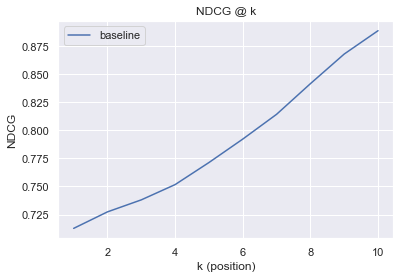

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

query_groups_with_azs_ranking = all_features.sort_values(['@search.score'], ascending=False).groupby('query_id')
ndcg_inputs = [[doc['grade'] for _, doc in group.iterrows()] for query_id, group in query_groups_with_azs_ranking]
original_ndcg = azs.evaluate_ndcg(k_start=1, k_end=10, baseline=ndcg_inputs, plot=True)

## Feature Normalization

Similarity scores are intended to be compared within the context of a single search query, where all documents are evaluated against the same search terms. The range of those scores fluctuate depending on what terms are being searched (for example, common terms often yield to lower similarity scores, since their document frenquency is higher).

To address this problem, we are going to normalize search related features (starting with '@search.') using the [minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) scaler, which will be applied at the query level group, so that all documents associated with a particular query will have their feature values scaled from 0 to 1.

As the name suggests, the **normalized_pageview** field already has some level of normalization applied. We are going to normalize those values further using the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) to reduce their range and create a normal distribution. We will apply the same type of transformation to other metadata based features, such as **table count, section count, and title length**.

Quantile transforming feature 'title_length_in_chars: 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]                             


,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.body_en_us.termFrequency,@search.features.description_en_us.uniqueTokenMatches,@search.features.description_en_us.similarityScore,...,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency,query_id,title_length_in_words,title_length_in_chars
3734,10,0.304274,0.780780,0.415634,1.644369,0.0,0.304274,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.189522,-0.983573
3735,8,0.591270,-1.475269,-5.199338,-5.199338,0.0,0.591270,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.447305,0.020074
3736,6,0.000000,-1.116369,0.415634,-1.068522,0.0,0.000000,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.487893,-0.208505
3737,4,1.000000,-1.242061,-5.199338,-1.068522,0.0,1.000000,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.487893,-0.703922
3738,3,0.248711,-1.280981,-5.199338,-1.068522,0.0,0.248711,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.447305,0.357496


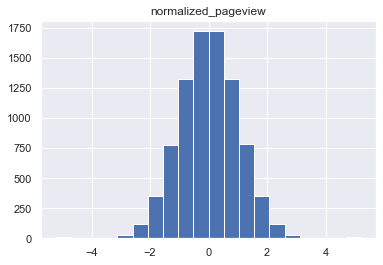

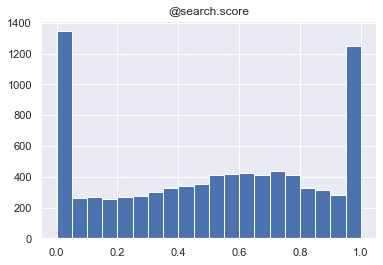

In [7]:
import numpy as np
from sklearn.preprocessing import minmax_scale, QuantileTransformer
from tqdm import tqdm

def normalize_features(features):
    query_groups = features.groupby('query_id')
    progress_bar = tqdm(features.columns)

    for feature in progress_bar:
        if feature.startswith("@search."):
            progress_bar.set_description(f"MinMax normalizing feature '{feature}'")
            features[feature] = query_groups[feature].transform(lambda x: minmax_scale(x.astype(float)))
        elif feature not in ['grade', 'query_id']:
            progress_bar.set_description(f"Quantile transforming feature '{feature}")
            features[[feature]] = QuantileTransformer(output_distribution='normal').fit_transform(features[[feature]])
        else:
            progress_bar.set_description(f"Skipping feature '{feature}")
        
    return features
    
df = normalize_features(all_features)
df[['normalized_pageview']].hist(bins=20)
df[['@search.score']].hist(bins=20)
df.head(5)

### Serialize Data for our Experiment

Let's serialize our data to disk. The tutorial will continue in [Part 2: Experiment](./l2r_part2_experiment.ipynb)



In [8]:
df.columns

Index(['grade', '@search.score', 'normalized_pageview', 'tableCount',
       'sectionCount', '@search.features.body_en_us.uniqueTokenMatches',
       '@search.features.body_en_us.similarityScore',
       '@search.features.body_en_us.termFrequency',
       '@search.features.description_en_us.uniqueTokenMatches',
       '@search.features.description_en_us.similarityScore',
       '@search.features.description_en_us.termFrequency',
       '@search.features.keyPhrases_en_us.uniqueTokenMatches',
       '@search.features.keyPhrases_en_us.similarityScore',
       '@search.features.keyPhrases_en_us.termFrequency',
       '@search.features.title_en_us.uniqueTokenMatches',
       '@search.features.title_en_us.similarityScore',
       '@search.features.title_en_us.termFrequency',
       '@search.features.searchTerms.uniqueTokenMatches',
       '@search.features.searchTerms.similarityScore',
       '@search.features.searchTerms.termFrequency',
       '@search.features.urlPath.uniqueTokenMatches',


In [9]:
interim_data_dir = Path.cwd() / 'data' / 'interim'
interim_data_dir.mkdir(parents=True, exist_ok=True)

df.to_csv(interim_data_dir / 'normalized_features.csv', index=False)